https://medium.com/towards-data-science/causal-machine-learning-for-customer-retention-a-practical-guide-with-python-6bd959b25741

In [39]:
import numpy as np
import pandas as pd
from causalml.dataset import make_uplift_classification
from causalml.inference.meta import BaseSRegressor, BaseTRegressor
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import auuc_score, plot_gain
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


In [40]:
n_uplift_increase_dict = {
    "email_campaign": 2,
    "in_app_notification": 3,
    "call_campaign": 3,
    "voucher": 4
}

In [41]:
# Dictionary specifying the number of features that will have a negative effect on retention for each treatment
n_uplift_decrease_dict = {
    "email_campaign": 1,
    "in_app_notification": 1,
    "call_campaign": 2,
    "voucher": 1
}

In [42]:
# Dictionary specifying the magnitude of positive effect on retention for each treatment
delta_uplift_increase_dict = {
    "email_campaign": 0.05,         # Email campaign increases retention by 5 percentage points
    "in_app_notification": 0.03,    # In-app notifications have a smaller but still positive effect
    "call_campaign": 0.08,          # Direct calls have a strong positive effect
    "voucher": 0.10                 # Vouchers have the strongest positive effect
}

In [43]:
# Dictionary specifying the magnitude of negative effect on retention for each treatment
delta_uplift_decrease_dict = {
    "email_campaign": 0.02,         # Email campaign might slightly decrease retention for some customers
    "in_app_notification": 0.01,    # In-app notifications have minimal negative effect
    "call_campaign": 0.03,          # Calls might annoy some customers more
    "voucher": 0.02                 # Vouchers might make some customers think the product is overpriced
}

In [44]:
# Dictionary specifying the number of mixed features (combination of informative and positive uplift) for each treatment
n_uplift_increase_mix_informative_dict = {
    "email_campaign": 1,
    "in_app_notification": 2,
    "call_campaign": 1,
    "voucher": 2
}

In [45]:
# Dictionary specifying the number of mixed features (combination of informative and negative uplift) for each treatment
n_uplift_decrease_mix_informative_dict = {
    "email_campaign": 1,
    "in_app_notification": 1,
    "call_campaign": 1,
    "voucher": 1
}

In [46]:
positive_class_proportion = 0.7  # Baseline retention rate

In [55]:
# Generate the dataset
df, feature_names = make_uplift_classification(
    n_samples=20000,                    # Increased sample size for more robust results
    treatment_name=["email_campaign", "in_app_notification", "call_campaign", "voucher", "control"],
    y_name="retention",
    n_classification_features=20,       # Increased number of features
    n_classification_informative=10,
    n_uplift_increase_dict=n_uplift_increase_dict,
    n_uplift_decrease_dict=n_uplift_decrease_dict,
    delta_uplift_increase_dict=delta_uplift_increase_dict,
    delta_uplift_decrease_dict=delta_uplift_decrease_dict,
    n_uplift_increase_mix_informative_dict=n_uplift_increase_mix_informative_dict,
    n_uplift_decrease_mix_informative_dict=n_uplift_decrease_mix_informative_dict,
    positive_class_proportion=positive_class_proportion,
    random_seed=42,
)


In [58]:
#Encoding treatments variables
encoding_dict = {
    'call_campaign': 3,
    'email_campaign': 1,
    'voucher': 4,
    'in_app_notification':2,
    'control': 0
}

# Create a new column with encoded values
df['treatment_group_numeric'] = df['treatment_group_key'].map(encoding_dict)

df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_informative,x7_informative,x8_informative,x9_informative,...,x41_uplift_decrease,x42_decrease_mix,x43_uplift_decrease,x44_uplift_decrease,x45_decrease_mix,x46_uplift_decrease,x47_decrease_mix,retention,treatment_effect,treatment_group_numeric
0,voucher,-1.750117,-0.513593,-1.285419,0.874743,-0.930628,-2.155293,-0.806022,-0.499746,1.461507,...,-1.130277,0.426987,2.032385,1.375074,-2.335993,-0.926782,0.254619,1,0,4
1,control,-1.774079,-1.137844,0.434705,0.572540,-1.321016,0.680291,-1.811594,0.941762,0.418591,...,-0.897736,0.996167,1.290391,1.084107,-1.641862,1.278699,-2.652908,0,0,0
2,email_campaign,-0.131225,-0.200455,-2.016290,-0.040993,-1.588070,1.491532,0.654839,-0.598274,-0.321064,...,-0.988495,0.149550,2.145553,1.401487,-1.802944,-1.420005,1.877844,1,0,1
3,voucher,-1.093582,-0.228472,-0.916035,-1.979672,-0.301334,0.851787,0.392479,-0.496639,-1.483684,...,-1.012099,0.174031,-1.467742,-2.467197,2.834534,-1.358422,1.612224,1,0,4
4,control,1.547017,0.790003,-1.154556,0.436507,-2.275716,1.064366,0.644147,-2.369035,1.485103,...,-1.051257,-0.743962,0.806831,0.966498,-0.154931,-2.114213,2.535442,1,0,0


In [60]:
def prepare_data(df, feature_names, y_name, test_size=0.3, random_state=42):
    """
    Prepare data for uplift modeling, including splitting into train and test sets,
    and creating mono-treatment subsets.
    """
    # Create binary treatment column
    df['treatment_col'] = np.where(df['treatment_group_key'] == 'control', 0, 1)

    # Split data into train and test sets
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

    # Create mono-treatment subsets
    df_train_mono = df_train[df_train['treatment_group_key'].isin(['email_campaign', 'control'])]
    df_test_mono = df_test[df_test['treatment_group_key'].isin(['email_campaign', 'control'])]

    # Prepare features, treatment, and target variables for full dataset
    X_train = df_train[feature_names].values
    X_test = df_test[feature_names].values
    treatment_train = df_train['treatment_group_key'].values
    treatment_test = df_test['treatment_group_key'].values
    y_train = df_train[y_name].values
    y_test = df_test[y_name].values

    # Prepare features, treatment, and target variables for mono-treatment dataset
    X_train_mono = df_train_mono[feature_names].values
    X_test_mono = df_test_mono[feature_names].values
    treatment_train_mono = df_train_mono['treatment_group_key'].values
    treatment_test_mono = df_test_mono['treatment_group_key'].values
    y_train_mono = df_train_mono[y_name].values
    y_test_mono = df_test_mono[y_name].values

    return {
        'df_train': df_train, 'df_test': df_test,
        'df_train_mono': df_train_mono, 'df_test_mono': df_test_mono,
        'X_train': X_train, 'X_test': X_test,
        'X_train_mono': X_train_mono, 'X_test_mono': X_test_mono,
        'treatment_train': treatment_train, 'treatment_test': treatment_test,
        'treatment_train_mono': treatment_train_mono, 'treatment_test_mono': treatment_test_mono,
        'y_train': y_train, 'y_test': y_test,
        'y_train_mono': y_train_mono, 'y_test_mono': y_test_mono
    }

# Usage
data = prepare_data(df, feature_names, "retention")

# Print shapes for verification
print(f"Full test set shape: {data['df_test'].shape}")
print(f"Mono-treatment test set shape: {data['df_test_mono'].shape}")


Full test set shape: (30000, 52)
Mono-treatment test set shape: (11901, 52)


In [61]:
data.keys()

dict_keys(['df_train', 'df_test', 'df_train_mono', 'df_test_mono', 'X_train', 'X_test', 'X_train_mono', 'X_test_mono', 'treatment_train', 'treatment_test', 'treatment_train_mono', 'treatment_test_mono', 'y_train', 'y_test', 'y_train_mono', 'y_test_mono'])

In [62]:
# Access prepared data
df_train, df_test = data["df_train"], data["df_test"]
df_train_mono, df_test_mono = data["df_train_mono"], data["df_test_mono"]
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]
X_train_mono, y_train_mono = data["X_train_mono"], data["y_train_mono"]
X_test_mono, y_test_mono = data["X_test_mono"], data["y_test_mono"]
treatment_train, treatment_test = data["treatment_train"], data["treatment_test"]
treatment_train_mono, treatment_test_mono = data["treatment_train_mono"], data["treatment_test_mono"]


* X_1 to X_n would be our user level features
* T would be the actual treatment (1 or 0, treatment or control, treatment 1, treatment 2, control depending on your use case)
* And Y is the actual outcome: did the user stay or not?

### Direct uplift model

This approach is the simplest one. We simply use a specific algorithm, such as an uplift decision tree, which loss function is optimized to solve this problem. These models are designed to maximize the difference in outcomes between treated and untreated groups within the same model.

In [65]:
df_results_mono = df_test_mono.copy()

# Initialize and train a randomForest Classifier
rfc = UpliftRandomForestClassifier(control_name='control')
rfc.fit(X_train_mono, treatment_train_mono, y_train_mono)

The S-Learner is the simplest meta-learner of all. Why? Because it only consists of using a traditional machine learning model that includes the treatment feature as input. While simple to implement, it may struggle if the importance of the treatment variable is low.

In [66]:
# Initialize and train S-Learner
learner_s = BaseSRegressor(
    learner=XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    control_name='control'
)

learner_s.fit(X_train_mono, treatment_train_mono, y_train_mono)

The T-Learner tries to solve the problem of discarding the treatment entirely by forcing the learner to first split on it. Instead of using a single model, we will use one model per treatment variable.

In the binary case, there are only two models that we need to estimate (hence the name T)

In [67]:
# Initialize and train T-Learner
learner_t = BaseTRegressor(
    learner=XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    control_name='control'
)

learner_t.fit(X_train_mono, treatment_train_mono, y_train_mono)

In [68]:
# Predict treatment effects
df_results_mono[["mono_S_learner"]] = learner_s.predict(X=X_test_mono)
df_results_mono[["mono_T_learner"]] = learner_t.predict(X=X_test_mono)
df_results_mono["random_forest_learner"] = rfc.predict(X_test_mono)

display(df_results_mono[["mono_S_learner", "mono_T_learner", "random_forest_learner"]].mean())

df_mono_results_plot = df_results_mono[["mono_S_learner","mono_T_learner", "random_forest_learner","retention","treatment_col"]].copy()

mono_S_learner           0.010568
mono_T_learner           0.006178
random_forest_learner    0.010139
dtype: float64

### Gain curve

The Gain curve: The gain curve offers an easy way to visualise our model’s performance. The idea behind gain is simple:

* We compute the estimated effect of each of our customers, order them from the biggest effect to the lesser.
* From here, we move point by point. At each point, we calculate the average treatment effect meaning, both the average effect — for control and treatment — and we take the difference.
* We do that for both our models ordering and a random ordering, simulating random selection, and compare both curves!

It helps us understand which improvement our model would have brought versus a random selection.

The AAUC score: the AAUC score is very close to the actual gain curve as it measures the Area under the curve of the gain curve of our model, enabling us to compare it with the one of the random model. It summarizes the gain curve in an easy to compare number.

AAUC Score Normalized: mono_S_learner           6.729288
mono_T_learner           6.364706
random_forest_learner    6.302013
Random                  -0.558465
dtype: float64


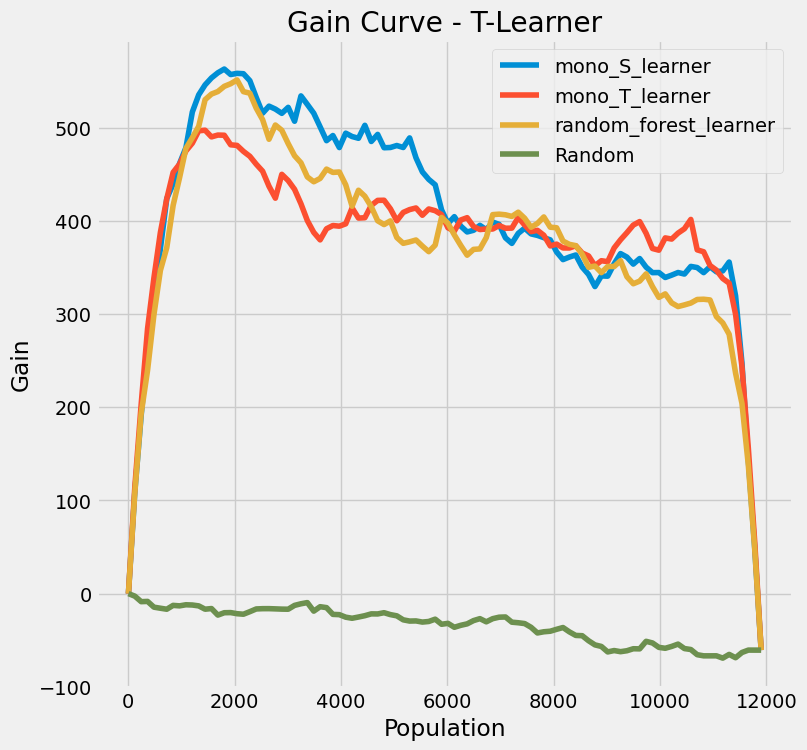

In [70]:
import matplotlib.pyplot as plt
# AAUC score
aauc_normalized = auuc_score(
    df_mono_results_plot, outcome_col="retention", treatment_col="treatment_col", normalize=True, tmle=False
)
print(f"AAUC Score Normalized: {aauc_normalized}")

# Plot Gain Curve
plot_gain(df_mono_results_plot, outcome_col="retention", treatment_col="treatment_col")
plt.title("Gain Curve - T-Learner")
plt.show()


* X-Axis (Population): This represents the size of the population you’re targeting, starting from the most responsive individuals (on the left) to the least responsive (on the right).
* Y-Axis (Gain): This shows the cumulative gain, which is the improvement in your outcome (e.g., increased retention).

The gain curve shows us the benefit — in our initial unit hence “people retained” — of targeting the population using our uplift model or randomly targeting.

In that case it seems that if we reach out to the whole population with our emails, we would retain approximately 100 additional users. This is our baseline scenario. Note that every curve ends by this result which is expected considering our gain definition.
So how to interpret this? Well, looking at the curve we can say that using our model, by reaching out to only 50% of the population, we can save 600 additional users! Six times more than by reaching out to everyone. How is that possible? By targeting only users that are likely to react positively to our outreach, while ignoring those who would leverage this email to actually churn for instance.

### Personalisation

In [71]:
df_results_multi = df_test.copy()

# Define treatment actions
actions = ["call_campaign", "email_campaign", "in_app_notification", "voucher"]

# Initialize and train Uplift Random Forest Classifier
rfc = UpliftRandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    min_samples_treatment=10,
    n_reg=10,
    control_name="control",
    random_state=42,
)
rfc.fit(X_train, treatment_train, y_train)

# Initialize and train S-Learner
learner_s = BaseSRegressor(
    learner=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42), control_name="control"
)

learner_s.fit(X_train, treatment_train, y_train)


In [72]:
# Initialize and train T-Learner
learner_t = BaseTRegressor(
    learner=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42), control_name="control"
)

learner_t.fit(X_train, treatment_train, y_train)

Now that our models are trained, let’s generate our predictions for each treatment. For each user, we’ll get the uplift of each treatment. This will enable us to choose the most effective treatment by user, if any treatment has a positive uplift. 

In [83]:
def predict_multi(df, learner, learner_name, X_test):
    """
    Predict treatment effects for multiple treatments and determine the best treatment.
    """

    # Predict treatment effects
    cols = [f"{learner_name}_learner_{action}" for action in actions]
    df[cols] = learner.predict(X=X_test)

    # Determine the best treatment effect
    df[f"{learner_name}_learner_effect"] = df[cols].max(axis=1)

    # Determine the best treatment
    df[f"{learner_name}_best_treatment"] = df[cols].idxmax(axis=1)
    df.loc[df[f"{learner_name}_learner_effect"] < 0, f"{learner_name}_best_treatment"] = "control"

    return df


# Apply predictions for each model
df_results_multi = predict_multi(df_results_multi, rfc, "rf", X_test)
df_results_multi = predict_multi(df_results_multi, learner_s, "s", X_test)
df_results_multi = predict_multi(df_results_multi, learner_t, "t", X_test)


In [84]:
print(df_results_multi.columns)

Index(['treatment_group_key', 'x1_informative', 'x2_informative',
       'x3_informative', 'x4_informative', 'x5_informative', 'x6_informative',
       'x7_informative', 'x8_informative', 'x9_informative', 'x10_informative',
       'x11_irrelevant', 'x12_irrelevant', 'x13_irrelevant', 'x14_irrelevant',
       'x15_irrelevant', 'x16_irrelevant', 'x17_irrelevant', 'x18_irrelevant',
       'x19_irrelevant', 'x20_irrelevant', 'x21_uplift_increase',
       'x22_uplift_increase', 'x23_increase_mix', 'x24_uplift_increase',
       'x25_uplift_increase', 'x26_uplift_increase', 'x27_increase_mix',
       'x28_increase_mix', 'x29_uplift_increase', 'x30_uplift_increase',
       'x31_uplift_increase', 'x32_increase_mix', 'x33_uplift_increase',
       'x34_uplift_increase', 'x35_uplift_increase', 'x36_uplift_increase',
       'x37_increase_mix', 'x38_increase_mix', 'x39_uplift_decrease',
       'x40_decrease_mix', 'x41_uplift_decrease', 'x42_decrease_mix',
       'x43_uplift_decrease', 'x44_uplift_d

### AAUC

In [85]:
df_results_multi = df_results_multi[['rf_learner_effect', 's_learner_effect', 't_learner_effect', "retention", "treatment_col"]]
df_results_multi.head()

,rf_learner_effect,s_learner_effect,t_learner_effect,retention,treatment_col
75721,0.158209,0.357900,0.450518,0,1
80184,0.027240,0.028601,-0.007816,1,0
19864,0.134333,0.229467,0.618539,0,0
76699,0.116074,0.137853,0.197795,1,1
92991,0.046044,0.082995,0.078843,1,1


AAUC Score Normalized: rf_learner_effect    2.153227
s_learner_effect     2.514358
t_learner_effect     2.521691
Random               0.525455
dtype: float64
AAUC Score: rf_learner_effect    771.160406
s_learner_effect     900.496414
t_learner_effect     903.122617
Random               188.187481
dtype: float64


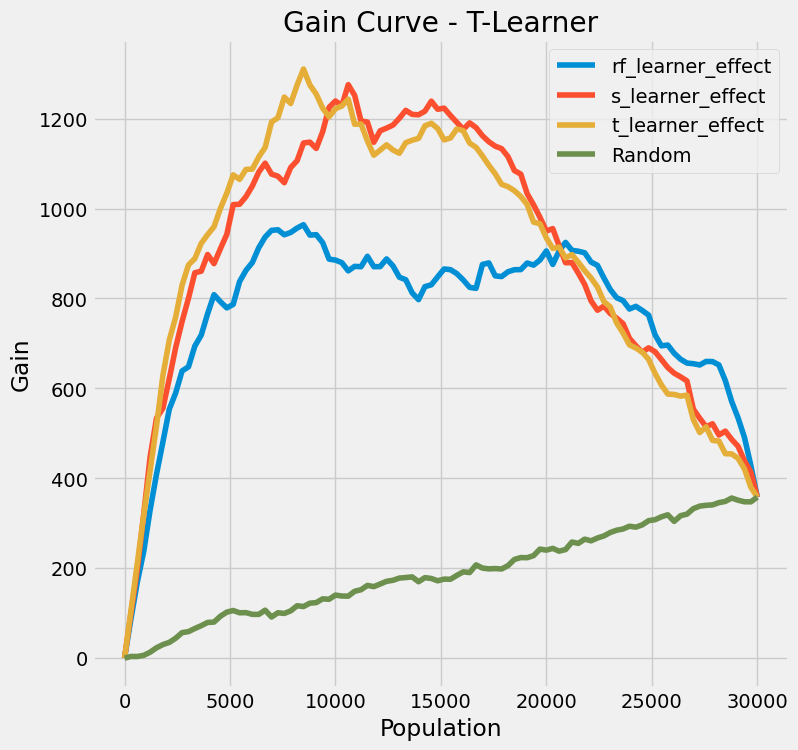

In [86]:
# AAUC score
aauc_normalized = auuc_score(
    df_results_multi, outcome_col="retention", treatment_col="treatment_col", normalize=True, tmle=False
)
aauc_non_normalize = auuc_score(
    df_results_multi, outcome_col="retention", treatment_col="treatment_col", normalize=False, tmle=False
)
print(f"AAUC Score Normalized: {aauc_normalized}")
print(f"AAUC Score: {aauc_non_normalize}")

# Plot Gain Curve
plot_gain(df_results_multi, outcome_col="retention", treatment_col="treatment_col")
plt.title("Gain Curve - T-Learner")
plt.show()


* As we can see, if we were to target 100% of our population — 30,000 users — we would retain an additional 850 users (approximately)
* however, using our models, we are able to retain 1,600 users while only contacting 33% of the total population
* Finally, we notice that past 40% of the population all curves start to decrease indicating that there is no value contacting those customers.